In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chess
import seaborn as sns
import time
import random
from chessboard import display


# sys.path.append('/../scripts/')
# from pgn_to_df import pgn_to_df
sns.set()
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("games.csv")
df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


In [3]:
# getting basic data and creating a copy of dataset
columns = df.columns
df_ = df.copy()
df_ = df_.drop(columns=['id', 'created_at', 'last_move_at'])
df_

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,True,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,True,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,True,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


```
Column names:
id
rated
created_at
last_move_at
turns
victory_status
winner
increment_code
white_id
white_rating
black_id
black_rating
moves
opening_eco
opening_name
opening_ply
```

In [4]:
pd.concat([df_['white_id'], df_['black_id']]).value_counts()

taranga               154
a_p_t_e_m_u_u          96
vladimir-kramnik-1     96
king5891               78
saviter                76
                     ... 
raoqwya                 1
perdanahitam1042        1
cincinnatus99           1
saidtugcu               1
ffbob                   1
Length: 15635, dtype: int64

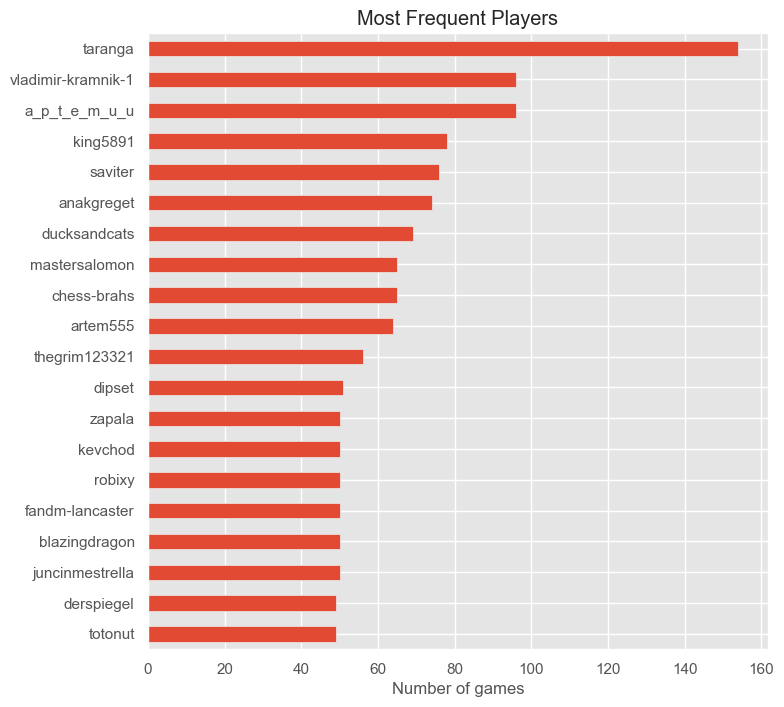

In [5]:
pd.concat([df_['white_id'], df_['black_id']]).value_counts(ascending=True).tail(20) \
    .plot(kind='barh', figsize=(8, 8), title="Most Frequent Players", xlabel='Number of games')
plt.show()

In [6]:
df_['opening_name'].value_counts()

Van't Kruijs Opening                                              368
Sicilian Defense                                                  358
Sicilian Defense: Bowdler Attack                                  296
Scotch Game                                                       271
French Defense: Knight Variation                                  271
                                                                 ... 
Sicilian Defense: Kupreichik Variation                              1
Modern Defense: Lizard Defense |  Mittenberger Gambit               1
French Defense: Rubinstein Variation |  Kasparov Attack             1
French Defense: Tarrasch Variation |  Open System |  Main Line      1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation        1
Name: opening_name, Length: 1477, dtype: int64

In [7]:
# keep when grouping by elo
# df.groupby(['rating_category'])['opening_names'].value_counts()

df_['opening_eco'].value_counts()

A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
A33       1
D22       1
E44       1
B58       1
D19       1
Name: opening_eco, Length: 365, dtype: int64

In [4]:
#First check if the ratings are within similar ranges

rating_diff = df_["white_rating"] - df_["black_rating"]
rating_range_within = abs(rating_diff) <= 1000
rating_range_out = abs(rating_diff) > 1000
print("out of {} games, {} games are within a range of 1,000 and {} games are not".format(len(df_), rating_range_within.sum(), rating_range_out.sum()))

out of 20058 games, 19996 games are within a range of 1,000 and 62 games are not


In [5]:
rating_bin = [0, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700]
labels = ["Novices", "E", "D", "C", "B", "A", "CM", "NM", "FM", "IM", "GM"]
df_['white_category'] = pd.cut(x = df_['white_rating'], bins = rating_bin, labels = labels, include_lowest = True)


In [6]:
df_['black_category'] = pd.cut(x = df_['black_rating'], bins = rating_bin, labels = labels, include_lowest = True)
df_.head()

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,white_category,black_category
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,C,E
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,D,D
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,C,C
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,C,C
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,C,C


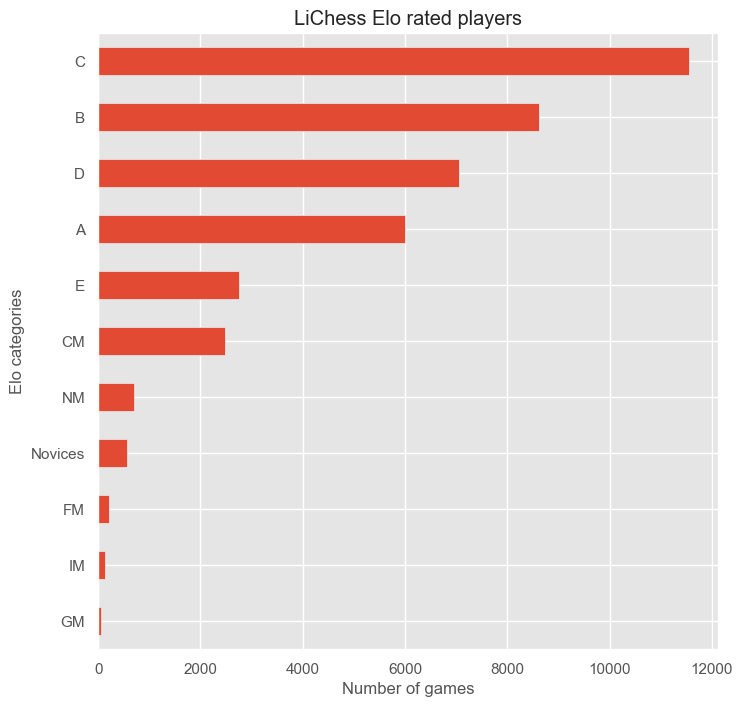

In [11]:
pd.concat([df_['white_category'], df_['black_category']]).value_counts(ascending=True).tail(20) \
    .plot(kind='barh', figsize=(8, 8), title="LiChess Elo rated players", xlabel='Number of games', ylabel='Elo categories')
plt.show()

```
What does this mean?
Well to give you some context:
    2700+	sometimes informally called "super grandmasters"
2500–2700	most Grandmasters (GM)
2400–2500	most International Masters (IM) and some Grandmasters (GM)
2300–2400	most FIDE Masters (FM) and some International Masters (IM)
2200–2300	FIDE Candidate Masters (CM), most national masters (NM)
2000–2200	Candidate masters (CM)
1800–2000	Class A, category 1
1600–1800	Class B, category 2
1400–1600	Class C, category 3
1200–1400	Class D, category 4
1000–1200	Class E, category 5
Below 1000	Novices

*Note: taken by https://en.wikipedia.org/wiki/Chess_ra
People who play LiChess more often are those with 1200 to 2000 elo, meaning above-average people play chess
ting_system000	Novices
```

Now on to other things

In [7]:
df_["elo_diff"] = df_['white_rating'] - df_['black_rating']
df_.head()

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,white_category,black_category,elo_diff
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,C,E,309
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,D,D,61
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,C,C,-4
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,C,C,-15
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,C,C,54


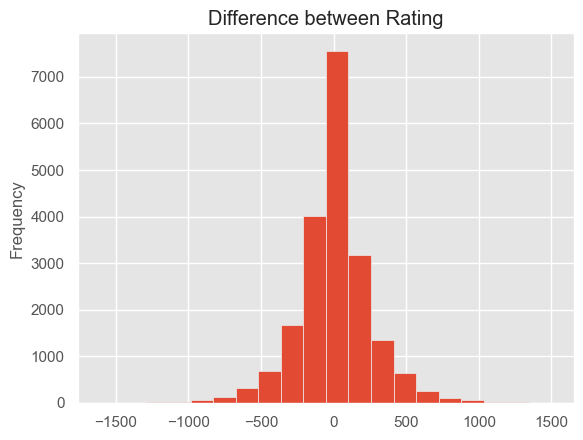

In [8]:
ax = df_["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating", xlabel='Elo difference')
plt.show()

In [9]:
df_[['white_rating', 'black_rating', 'elo_diff', 'winner']]

,white_rating,black_rating,elo_diff,winner
0,1500,1191,309,white
1,1322,1261,61,black
2,1496,1500,-4,white
3,1439,1454,-15,white
4,1523,1469,54,white
...,...,...,...,...
20053,1691,1220,471,white
20054,1233,1196,37,black
20055,1219,1286,-67,white
20056,1360,1227,133,white


In [11]:
# displays the matches where the high-rated player wins the match
df_upsets = (
    df_.query("(white_rating < black_rating and winner == 'white') or (white_rating > black_rating and winner == 'black')"
             )
    .reset_index(drop=True)
    .copy()
)

df_upsets[['white_rating', 'black_rating', 'elo_diff', 'winner']]

,white_rating,black_rating,elo_diff,winner
0,1322,1261,61,black
1,1496,1500,-4,white
2,1439,1454,-15,white
3,1439,1392,47,black
4,1094,1141,-47,white
...,...,...,...,...
6561,1222,1262,-40,white
6562,1237,1231,6,black
6563,1219,1250,-31,white
6564,1233,1196,37,black


In [26]:
df_upsets.sort_values(by=['elo_diff'])
final = df_upsets.reset_index()
final.to_csv("upset_dataset")


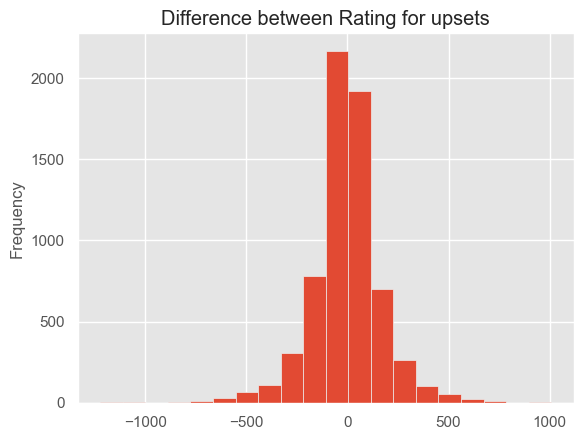

In [12]:
upset = df_upsets[['white_rating', 'black_rating']].max(axis=1)
ax = df_upsets["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating for upsets", xlabel='Elo difference')
plt.show()

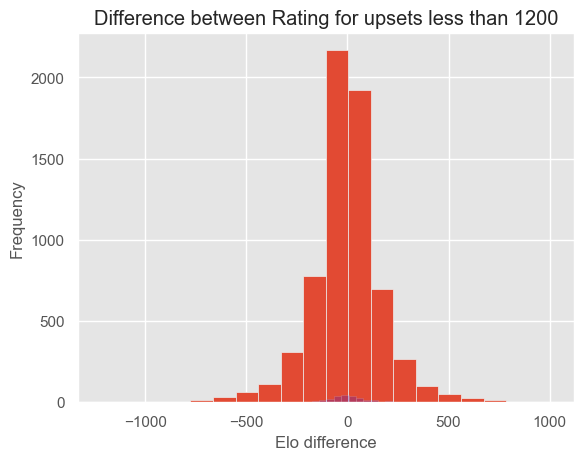

In [13]:
ax = df_upsets["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating for upsets")
ax = df_upsets["elo_diff"].loc[upset <= 1200].plot(kind="hist", bins = 20, title="Difference between Rating for upsets less than 1200", color='blue', alpha=0.2)

ax.set_xlabel("Elo difference")
plt.show()
ax.set_xlabel("Elo difference")
plt.show()

#different upsets

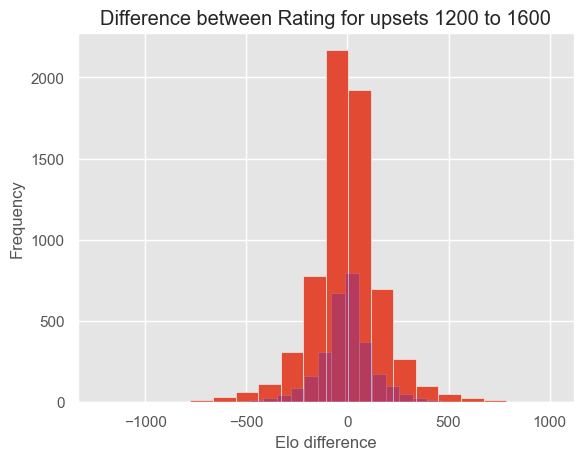

In [14]:
ax = df_upsets["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating for upsets")
mask = (upset > 1200) & (upset <= 1600)
ax = df_upsets["elo_diff"].loc[mask].plot(kind="hist", bins = 20, title="Difference between Rating for upsets 1200 to 1600", color='blue', alpha=0.2)

ax.set_xlabel("Elo difference")
plt.show()
ax.set_xlabel("Elo difference")
plt.show()


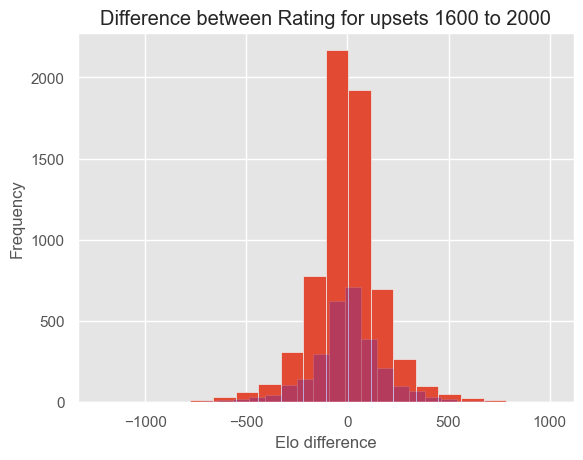

In [15]:
ax = df_upsets["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating for upsets")
mask = (upset > 1600) & (upset <= 2000)
ax = df_upsets["elo_diff"].loc[mask].plot(kind="hist", bins = 20, title="Difference between Rating for upsets 1600 to 2000", color='blue', alpha=0.2)

ax.set_xlabel("Elo difference")
plt.show()
ax.set_xlabel("Elo difference")
plt.show()


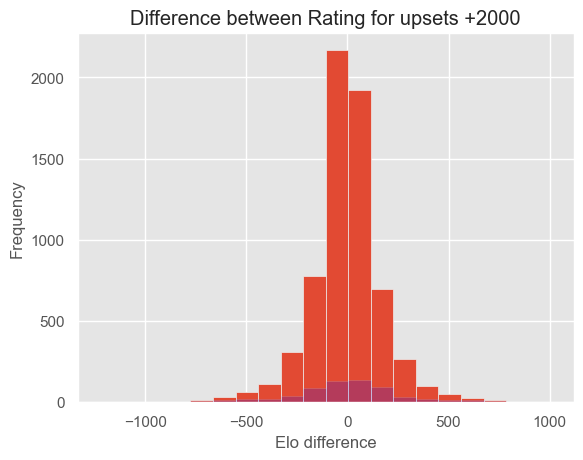

In [16]:
ax = df_upsets["elo_diff"].plot(kind="hist", bins = 20, title="Difference between Rating for upsets")
ax = df_upsets["elo_diff"].loc[upset > 2000].plot(kind="hist", bins = 20, title="Difference between Rating for upsets +2000", color='blue', alpha=0.2)

ax.set_xlabel("Elo difference")
plt.show()
ax.set_xlabel("Elo difference")
plt.show()


Looking at the matches. For time sake we will only look at upset matches since we already have the data prepared

In [21]:
cond = df_upsets['victory_status'] != 'outoftime'
cond1 = df_upsets['white_category'] == 'C'
match_history = df_upsets['moves'].where(cond & cond1)
match_history = match_history.dropna()
match_history

1        e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...
2        d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...
3                           e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4
11       d4 d5 h3 Nc6 Nf3 Nf6 Bg5 h6 Bxf6 exf6 e3 Bb4+ ...
14       e4 c5 Bc4 Nf6 Nc3 d6 Nf3 g6 Ng5 e6 d3 Bg7 O-O ...
                               ...                        
12292    d4 Nf6 Nf3 e6 a3 c5 e3 b6 Be2 Nc6 c3 Bb7 O-O B...
12322    e4 e5 Nf3 Nc6 d4 exd4 Bc4 Bc5 c3 Nf6 e5 d5 exf...
12337    e4 d6 d4 Nf6 Nc3 Nc6 Nf3 e5 dxe5 dxe5 Qxd8+ Kx...
12340    e4 e5 Nf3 Nc6 Bc4 Bc5 b4 Bxb4 c3 Ba5 Qb3 Qf6 O...
12344    e4 e6 d4 d5 e5 Nc6 Nf3 f6 Bb5 Bd7 O-O Nge7 exf...
Name: moves, Length: 3104, dtype: object

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . p . . . .
. . . . p . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . p . . . .
. . . . p . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R

r . b q k b n r
p p p . . p p p
. . n p . . . .
. . . . p . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R

r . b q k b n r
p p p . . p p p
. . n p . . . .
. . . P p . . .
. . . . P . . .
. . . . . N . .
P 

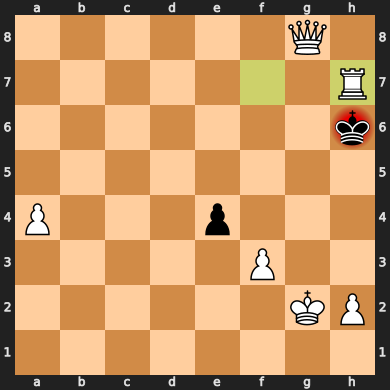

In [22]:
board = chess.Board()
print(board)
test_moves = match_history[1]
test_moves = test_moves.split()
for move in test_moves:
    board.push_san(move)
    print(board)
    print()
board

Does not look appealing, and only one board is shown, which is the end of the moves list

In [2]:
#so instead, after hours of searching and reading, used someone's code
# https://jupyter.brynmawr.edu/services/public/dblank/CS371%20Cognitive%20Science/2016-Fall/Programming%20a%20Chess%20Player.ipynb
import play_chess as pc
import chess

In [3]:
pc.play_game(pc.random_player, pc.random_player)

draw: insufficient material


(None, 'draw: insufficient material', Board('8/1K6/4k3/8/8/8/8/8 b - - 0 265'))

## Now, with a working chessboard, let's see if we can visualize the matches

In [25]:
mask = (upset > 1200) & (upset <= 1600) & (upset)
mid_elo_upsets = df_upsets["elo_diff"].loc[mask].sort_values()
print("These are the min and max upsets in the mid elo ranking(1200 to 1600): \n {} and {}\n".format(df_upsets['elo_diff'].loc[7117], df_upsets['elo_diff'].loc[528]))
print("{} \n---------------------------------------------------------\n{}".format(df_upsets.loc[528], df_upsets.loc[7117]))
high_upset, low_upset = df_upsets.loc[528], df_upsets.loc[7117]
#mid_elo_upsets

These are the min and max upsets in the mid elo ranking(1200 to 1600): 
 -656 and 713

rated                                                          True
turns                                                            29
victory_status                                               resign
winner                                                        white
increment_code                                                 10+8
                                        ...                        
opening_name      Scandinavian Defense: Main Line |  Mieses Vari...
opening_ply                                                       8
white_category                                                    C
black_category                                              Novices
elo_diff                                                        713
Name: 528, Length: 16, dtype: object 
---------------------------------------------------------
rated                        False
turns                            2

In [26]:
elo_list = [(0, 1200), (1200, 1600), (1600, 2000), (2000, 3000)]
for set in elo_list:
    print(set)
    mask = (upset > set[0]) & (upset <= set[1]) & (upset)
    mid_elo_upsets = df_upsets["elo_diff"].loc[mask].sort_values()
    print(mid_elo_upsets.max(), mid_elo_upsets.min())
    #print(mid_elo_upsets.index)
    

(0, 1200)
281 -362
(1200, 1600)
633 -599
(1600, 2000)
976 -951
(2000, 3000)
1499 -1605


In [27]:
# condition for number of moves made

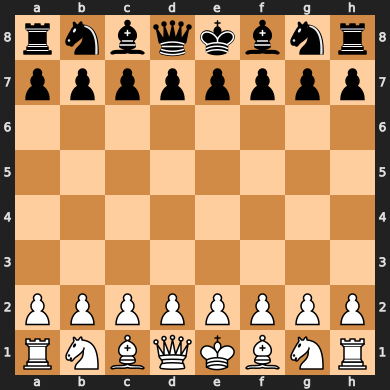

In [28]:
board = chess.Board()
board

move = df_upsets["moves"].loc[7117]
test_moves = move.split()
board = chess.Board()
board
for ply, move in enumerate(test_moves): 
    board.push_san(move)
    print(move)
    #display.update(board.fen())
    #time.sleep(1)
board

move = df_upsets['moves'].loc[528]
test_moves = move.split()
board = chess.Board()
for ply, move in enumerate(test_moves): 
    board.push_san(move)
    print(move)
    #display.update(board.fen())
    #time.sleep(1)
board

In [34]:
move = df_upsets['moves'].loc[528]
test_moves = move.split()
pc.game_match(test_moves)

InvalidMoveError: expected uci string to be of length 4 or 5: 'e4'

In [ ]:
df_upsets.victory_status.value_counts()